# Monitoring coastal erosion along Indonesia's coastline

## Description

In this example, we demonstrate a simplified version of the Coastlines method that combines data from the Sentinel-2 satellites with image compositing and tide filtering techniques to accurately map shorelines across time and identify areas that have changed significant. 
This example demonstrates how to:

1.  Load cloud-free Sentinel-2 time series data
2.  Compute a water index (MNDWI)
3.  Filter images by tide height using INATIDES model
4.  Create "summary" or composite images for given time periods
5.  Extract and visualise shorelines across time

***


## Getting started
**To run this analysis**, run all the cells in the notebook, starting with the "Load packages" cell.

**After finishing the analysis**, return to the "Analysis parameters" cell, modify some values (e.g. choose a different location or time period to analyse) and re-run the analysis.
There are additional instructions on modifying the notebook at the end.

### Load packages
Load key Python packages and supporting functions for the analysis.

In [3]:
%matplotlib inline

import os
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask
import dask.distributed


from dea_tools.bandindices import calculate_indices
from dea_tools.datahandling import mostcommon_crs
from dea_tools.plotting import display_map, rgb, xr_animation
from dea_tools.spatial import subpixel_contours, points_on_line
from eo_tides.stats import tide_stats
from eo_tides import tag_tides, list_models, pixel_tides
from pyTMD.io.model import load_database

from coastlines.utils import extract_contours, tide_cutoffs
from coastlines.vector import annual_movements, calculate_regressions
from dask.distributed import Client
from datacube import Datacube
from datacube.utils.masking import create_mask_value, valid_data_mask
from ipyleaflet import basemaps
from odc.geo.geom import point
from odc.stac import configure_s3_access



Set Up Environment

In [4]:
# Tide data and config
tide_data_location = "~/jovyan/data/coastlines/tide_models"

# Configure AWS
os.environ["AWS_DEFAULT_REGION"] = "us-west-2"

if "AWS_NO_SIGN_REQUEST" in os.environ:
    del os.environ["AWS_NO_SIGN_REQUEST"]

configure_s3_access(requester_pays=True)

# Connect to the Datacube
dc = Datacube(app="coastlines")

# Set up a dask client
dask_client = Client(n_workers=4, threads_per_worker=8)
dask_client

/opt/conda/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45259 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:45259/status,
Dashboard: http://127.0.0.1:45259/status,Workers: 4
Total threads: 32,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34873,Workers: 0
Dashboard: http://127.0.0.1:45259/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:39253,Total threads: 8
Dashboard: http://127.0.0.1:35535/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:45095,


### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

### Analysis parameters

The following cell set important parameters for the analysis:

* `lat_range`: The latitude range to analyse (e.g. `(-8.3463, -8.31713)`). 
For reasonable load times, keep this to a range of ~0.1 degrees or less.
* `lon_range`: The longitude range to analyse (e.g. `(115.62202, 115.67076)`). 
For reasonable load times, keep this to a range of ~0.1 degrees or less.
* `time_range`: The date range to analyse (e.g. `('2017', '2024') `)
* `time_step`: This parameter allows us to choose the length of the time periods we want to compare: e.g. shorelines for each year, or shorelines for each six months etc. 
`1Y` will generate one coastline for every year in the dataset; `6M` will produce a coastline for every six months, etc.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example explores coastal change in Karangasem, Bali Island. 

To ensure that the tidal modelling part of this analysis works correctly, please make sure the **centre of the study area is located over water** when setting `lat_range` and `lon_range`.


In [5]:
lat_range = (-8.3463, -8.31713)
lon_range = (115.62202, 115.67076)
time_range = ('2017', '2024')
time_step = '1Y'

## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [6]:
display_map(x=lon_range, y=lat_range)

## Load cloud-masked Sentinel data
The first step in this analysis is to load in Sentinel data for the `lat_range`, `lon_range` and `time_range` we provided above. 
The code below first connects to the datacube database, and then uses the `load_ard` function to load in data from sentinel-2 satellites for the area and time included in `lat_range`, `lon_range` and `time_range`. 
The function will also automatically mask out clouds from the dataset, allowing us to focus on pixels that contain useful data:

In [11]:
# Create the 'query' dictionary object, which contains the longitudes, 
# latitudes and time provided above
query = {
    'y': lat_range,
    'x': lon_range,
    'time': time_range,
    'measurements': ['blue', 'green', 'red', 'swir_1'],
    'resolution': (-20, 20),
}

# Identify the most common projection system in the input query 
output_crs = mostcommon_crs(dc=dc, product='s2_l2a', query=query)

# # Load available data from Sentinel-2 satellites
# sentinel_ds = load(
#     dc=dc,
#     products=[
#         's2_l2a'
#     ],
#     output_crs=output_crs,
#     group_by='solar_day',
#     dask_chunks={},
#     **query
# )

sentinel_ds = dc.load(
    product="s2_l2a",
    measurements=["red", "green", "blue", "nir08", "swir16", "swir22", "scl"],
    output_crs=output_crs,
    resolution=20,
    time=time_range,
    longitude=lon_range,
    latitude=lat_range,
    dask_chunks={},
    group_by="solar_day",
)

Querying product Product(name='s2_l2a', id_=9)
Querying product Product(name='s2_l2a', id_=9)


**Once the load is complete**, examine the data by printing it in the next cell.
The `Dimensions` argument revels the number of time steps in the data set, as well as the number of pixels in the `x` (longitude) and `y` (latitude) dimensions.

In [12]:
sentinel_ds

<xarray.Dataset> Size: 213MB
Dimensions:      (time: 373, y: 163, x: 270)
Coordinates:
  * time         (time) datetime64[ns] 3kB 2018-01-08T02:40:04.929000 ... 202...
  * y            (y) float64 1kB 9.08e+06 9.08e+06 ... 9.077e+06 9.077e+06
  * x            (x) float64 2kB 3.482e+05 3.483e+05 ... 3.536e+05 3.536e+05
    spatial_ref  int32 4B 32750
Data variables:
    red          (time, y, x) uint16 33MB dask.array<chunksize=(1, 163, 270), meta=np.ndarray>
    green        (time, y, x) uint16 33MB dask.array<chunksize=(1, 163, 270), meta=np.ndarray>
    blue         (time, y, x) uint16 33MB dask.array<chunksize=(1, 163, 270), meta=np.ndarray>
    nir08        (time, y, x) uint16 33MB dask.array<chunksize=(1, 163, 270), meta=np.ndarray>
    swir16       (time, y, x) uint16 33MB dask.array<chunksize=(1, 163, 270), meta=np.ndarray>
    swir22       (time, y, x) uint16 33MB dask.array<chunksize=(1, 163, 270), meta=np.ndarray>
    scl          (time, y, x) uint8 16MB dask.array<chunksize=(1, 163, 270), meta=np.ndarray>
Attributes:
    crs:           EPSG:32750
    grid_mapping:  spatial_ref

### Plot example timestep in true colour
To visualise the data, use the pre-loaded `rgb` utility function to plot a true colour image for a given time-step. 
White areas indicate where clouds or other invalid pixels in the image have been masked.

Change the value for `timestep` and re-run the cell to plot a different timestep (timesteps are numbered from `0` to `n_time - 1` where `n_time` is the total number of timesteps; see the `time` listing under the `Dimensions` category in the dataset print-out above).


In [15]:
subset = sentinel_ds[["red", "green", "blue"]].isel(time=slice(0, 4))
subset.to_array().plot.imshow(col="time", col_wrap=2, size=6, robust=True)


--- Logging error ---
Traceback (most recent call last):
  File "/opt/conda/lib/python3.12/site-packages/distributed/protocol/pickle.py", line 63, in dumps
    result = pickle.dumps(x, **dump_kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't pickle local object 'Mapper.__init__.<locals>.<lambda>'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.12/site-packages/distributed/protocol/pickle.py", line 68, in dumps
    pickler.dump(x)
AttributeError: Can't pickle local object 'Mapper.__init__.<locals>.<lambda>'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.12/site-packages/distributed/protocol/pickle.py", line 80, in dumps
    result = cloudpickle.dumps(x, **dump_kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.12/site-packages/cloudpickle/cloudpickle.py

TypeError: Could not serialize object of type _HLGExprSequence

## Compute Modified Normalised Difference Water Index
To extract shoreline locations, we need to be able to seperate water from land in our study area. 
To do this, we can use our Sentinel data to calculate a water index called the `Modified Normalised Difference Water Index`, or MNDWI. 
This index uses the ratio of green and mid-infrared radiation to identify the presence of water [(Xu 2006)](https://www.researchgate.net/publication/232724072_Modification_of_Normalized_Difference_Water_Index_NDWI_to_Enhance_Open_Water_Features_in_Remotely_Sensed_Imagery). 
The formula is:

$$
\begin{aligned}
\text{MNDWI} &= \frac{(\text{Green} - \text{MIR})}{(\text{Green} + \text{MIR})}
\end{aligned}
$$

where `Green` is the green band and `MIR` is the mid-infrared band. 
For Sentinel, we can use the Short-wave Infrared (SWIR) 1 band as our measure for `MIR`.

When it comes to interpreting the index, **High values (greater than 0, blue colours) typically represent water pixels**, while **low values (less than 0, red colours) represent land**. 
You can use the cell below to calculate and plot one of the images after calculating the index.

In [14]:
# Calculate the water index
sentinel_ds = calculate_indices(sentinel_ds, index='MNDWI', 
                               collection='s2')

# Plot the resulting image for the same timestep selected above
sentinel_ds.MNDWI.isel(time=timestep).plot(cmap='RdBu',
                                          size=6,
                                          aspect=1,
                                          vmin=-0.8,
                                          vmax=0.8)


ValueError: 's2' is not a valid option for `collection`. Please specify either 
'ga_ls_3', 'ga_s2_3' or 'ga_gm_3'

How does the plot of the index compare to the optical image from earlier? Was there water or land anywhere you weren't expecting?

## Model tide heights
The location of the shoreline can vary greatly from low to high tide. In the code below, we aim to reduce the effect of tides by modelling tide height data, and keeping only the satellite images that were taken at specific tidal conditions. We are telling the analysis to focus only on satellite images taken at mid-tide (e.g. when the tide was between the lowest 25th percentileand highest 75th percentile of tide heights).

The `tag_tides` function from eo_tides below uses the *INATIDES tidal model* to calculate the height of the tide at the exact moment each satellite image in our dataset was taken, and adds this as a new `tide_m` attribute in our dataset. 

In [102]:
# # Load Tides Model

directory="/home/ubuntu/Scripts/deafrica_tools/tide_models/"
model="INATIDES"

# Plot list of available models. This tests if the INATIDES model is available.
available_models, valid_models = list_models(directory, show_available=False, show_supported=False, raise_error=True)
if "INATIDES" in valid_models:
    print("INATIDES is a working model.")

if "INATIDES" not in available_models:
    print("INATIDES is not available in the tide directory. Check the path or model name.")

INATIDES is a working model.


In [103]:
# # Calculate tides for each timestep in the satellite dataset

sentinel_ds['tide_m'] = tag_tides(
    data=sentinel_ds,
    model=model,
    directory=directory,
)

# Print modelled tides
sentinel_ds

Setting tide modelling location from dataset centroid: 115.65, -8.33
Modelling tides with INATIDES


<xarray.Dataset> Size: 462MB
Dimensions:      (time: 525, y: 163, x: 270)
Coordinates:
  * time         (time) datetime64[ns] 4kB 2017-01-03T02:33:26.269000 ... 202...
  * y            (y) float64 1kB 9.08e+06 9.08e+06 ... 9.077e+06 9.077e+06
  * x            (x) float64 2kB 3.482e+05 3.483e+05 ... 3.536e+05 3.536e+05
    spatial_ref  int32 4B 32750
    tide_model   <U8 32B 'INATIDES'
Data variables:
    blue         (time, y, x) float32 92MB dask.array<chunksize=(1, 163, 270), meta=np.ndarray>
    green        (time, y, x) float32 92MB dask.array<chunksize=(1, 163, 270), meta=np.ndarray>
    red          (time, y, x) float32 92MB dask.array<chunksize=(1, 163, 270), meta=np.ndarray>
    swir_1       (time, y, x) float32 92MB dask.array<chunksize=(1, 163, 270), meta=np.ndarray>
    MNDWI        (time, y, x) float32 92MB dask.array<chunksize=(1, 163, 270), meta=np.ndarray>
    tide_m       (time) float32 2kB -0.4246 0.09596 0.04798 ... -0.39 0.08535
Attributes:
    crs:           epsg:32750
    grid_mapping:  spatial_ref

Using tide modelling location: 115.65, -8.33


Modelling tides with INATIDES
Using tide modelling location: 115.65, -8.33
Modelling tides with INATIDES


🌊 Modelled astronomical tide range: 2.28 m (-1.25 to 1.03 m).
🛰️ Observed tide range: 1.58 m (-0.69 to 0.89 m).

🔴 69% of the modelled astronomical tide range was observed at this location.
🟢 The highest 6% (0.14 m) of the tide range was never observed.
🔴 The lowest 25% (0.56 m) of the tide range was never observed.

🌊 Mean modelled astronomical tide height: 0.00 m.
🛰️ Mean observed tide height: 0.11 m.
⬆️ The mean observed tide height was 0.11 m higher than the mean modelled astronomical tide height.


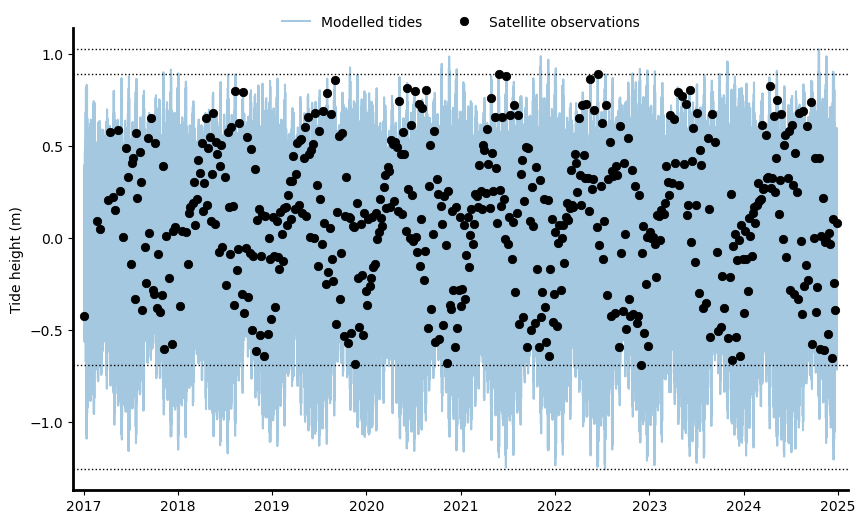

In [ ]:
# Display tides statistic
stats = tide_stats(
    data=sentinel_ds,
    model=model,
    directory=directory,
)

Now that we have modelled tide heights, we can plot them to visualise the range of tide that was captured by Sentinel-2 across our time series. 
In the plot below, red dashed lines also show the subset of the tidal range we selected using the `tide_range` parameter. 
The plot should make it clear that limiting the range of the tides for the analysis should give you more consistent results. 
A large variance in the tide height could obscure your results, so consistency is critical as you want to compare the change in the shoreline from year to year.

Low tide threshold: -0.40 metres AMSL
High tide threshold: 0.59 metres AMSL


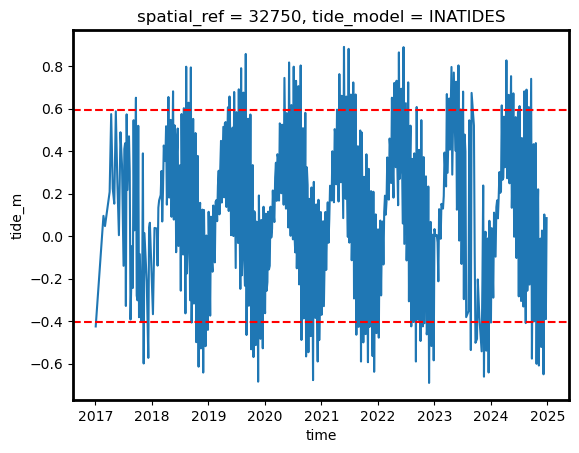

In [123]:
# Calculate low and high tide height thresholds
lowtide_cutoff = float(stats['mot'])
hightide_cutoff = float(stats['hot'])
lowtide_thresh, hightide_thresh = sentinel_ds.tide_m.quantile([lowtide_cutoff, hightide_cutoff])
print(f"Low tide threshold: {lowtide_thresh:.2f} metres AMSL")
print(f"High tide threshold: {hightide_thresh:.2f} metres AMSL")

# Plot the resulting tide heights for each Sentinel image:
sentinel_ds.tide_m.plot()
plt.axhline(lowtide_thresh, c='red', linestyle='--')
plt.axhline(hightide_thresh, c='red', linestyle='--')

### Filter Sentinel images by tide height
Here we take the Sentinel dataset and only keep the images with tide heights we want to analyse (i.e. tides within the heights given by tide height treshold). This will result in a smaller number of images (e.g. ~400 images compared to ~900):

In [124]:
# Keep timesteps larger than the min tide, and smaller than the max tide
sentinel_filtered = sentinel_ds.sel(time=(sentinel_ds.tide_m > lowtide_thresh) &
                                       (sentinel_ds.tide_m <= hightide_thresh))
sentinel_filtered

<xarray.Dataset> Size: 359MB
Dimensions:      (time: 408, y: 163, x: 270)
Coordinates:
  * time         (time) datetime64[ns] 3kB 2017-02-22T02:39:31.461000 ... 202...
  * y            (y) float64 1kB 9.08e+06 9.08e+06 ... 9.077e+06 9.077e+06
  * x            (x) float64 2kB 3.482e+05 3.483e+05 ... 3.536e+05 3.536e+05
    spatial_ref  int32 4B 32750
    tide_model   <U8 32B 'INATIDES'
Data variables:
    blue         (time, y, x) float32 72MB dask.array<chunksize=(1, 163, 270), meta=np.ndarray>
    green        (time, y, x) float32 72MB dask.array<chunksize=(1, 163, 270), meta=np.ndarray>
    red          (time, y, x) float32 72MB dask.array<chunksize=(1, 163, 270), meta=np.ndarray>
    swir_1       (time, y, x) float32 72MB dask.array<chunksize=(1, 163, 270), meta=np.ndarray>
    MNDWI        (time, y, x) float32 72MB dask.array<chunksize=(1, 163, 270), meta=np.ndarray>
    tide_m       (time) float32 2kB 0.09596 0.04798 0.2086 ... -0.39 0.08535
Attributes:
    crs:           epsg:32750
    grid_mapping:  spatial_ref

## Combine observations into noise-free summary images
Individual remote sensing images can be affected by noisy data, including clouds, sunglint and poor water quality conditions (e.g. sediment). To produce cleaner images that can be compared more easily across time, we can create 'summary' images or composites that combine multiple images into one image to reveal the median or 'typical' appearance of the landscape for a certain time period. In this case, we use the median as the summary statistic because it prevents strong outliers (like masked cloud values) from skewing the data, which would not be the case if we were to use the mean.

In the code below, we take the time series of images and combine them into single images for each `time_step`. For example, if `time_step = '2Y'`, the code will produce one new image for each two-year period in the dataset. This step can take **several minutes to load** if the study area is large.

/home/ubuntu/miniforge3/envs/cubeenv/lib/python3.12/site-packages/xarray/groupers.py:392: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


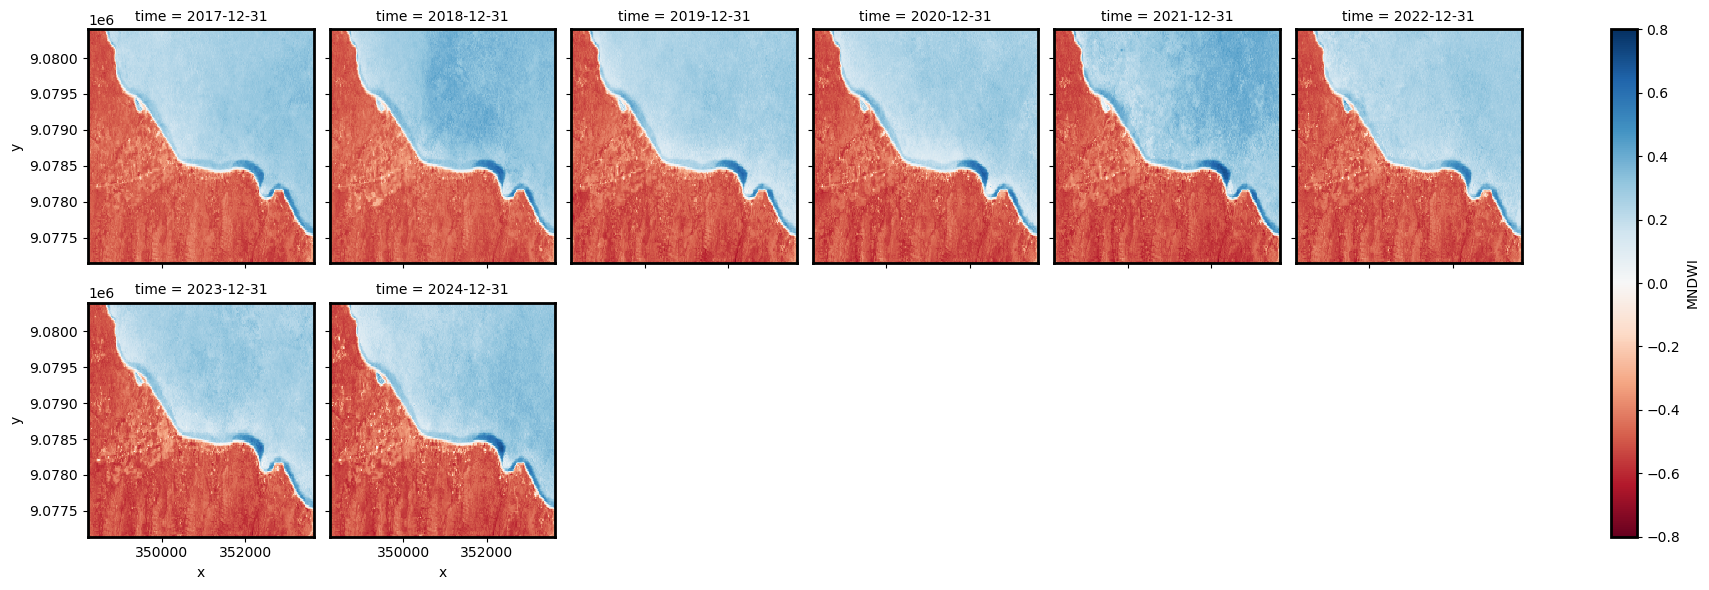

In [125]:
# Combine into summary images by `time_step`
sentinel_summaries = (sentinel_filtered.MNDWI
                     .compute()
                     .resample(time=time_step, closed='left')
                     .median('time'))

# Shut down Dask client now that we have processed the data we need
client.close()

# Plot the output summary images
sentinel_summaries.plot(col='time',
                       cmap='RdBu',
                       col_wrap=6,
                       vmin=-0.8,
                       vmax=0.8)


## Extract shorelines from imagery
We now want to extract an accurate shoreline for each each of the summary images above 
The code below identifies the boundary between land and water by tracing a line along pixels with a water index value of `0` (halfway between land and water water index values). 
It returns a `geopandas.GeoDataFrame` with one line feature for each time step:


Operating in single z-value, multiple arrays mode
Writing contours to /home/ubuntu/Scripts/users/teguh/coastline_INATIDES.geojson


<Axes: title={'center': 'spatial_ref = 32750, tide_model = INATIDES, tim...'}, xlabel='x [metre]', ylabel='y [metre]'>

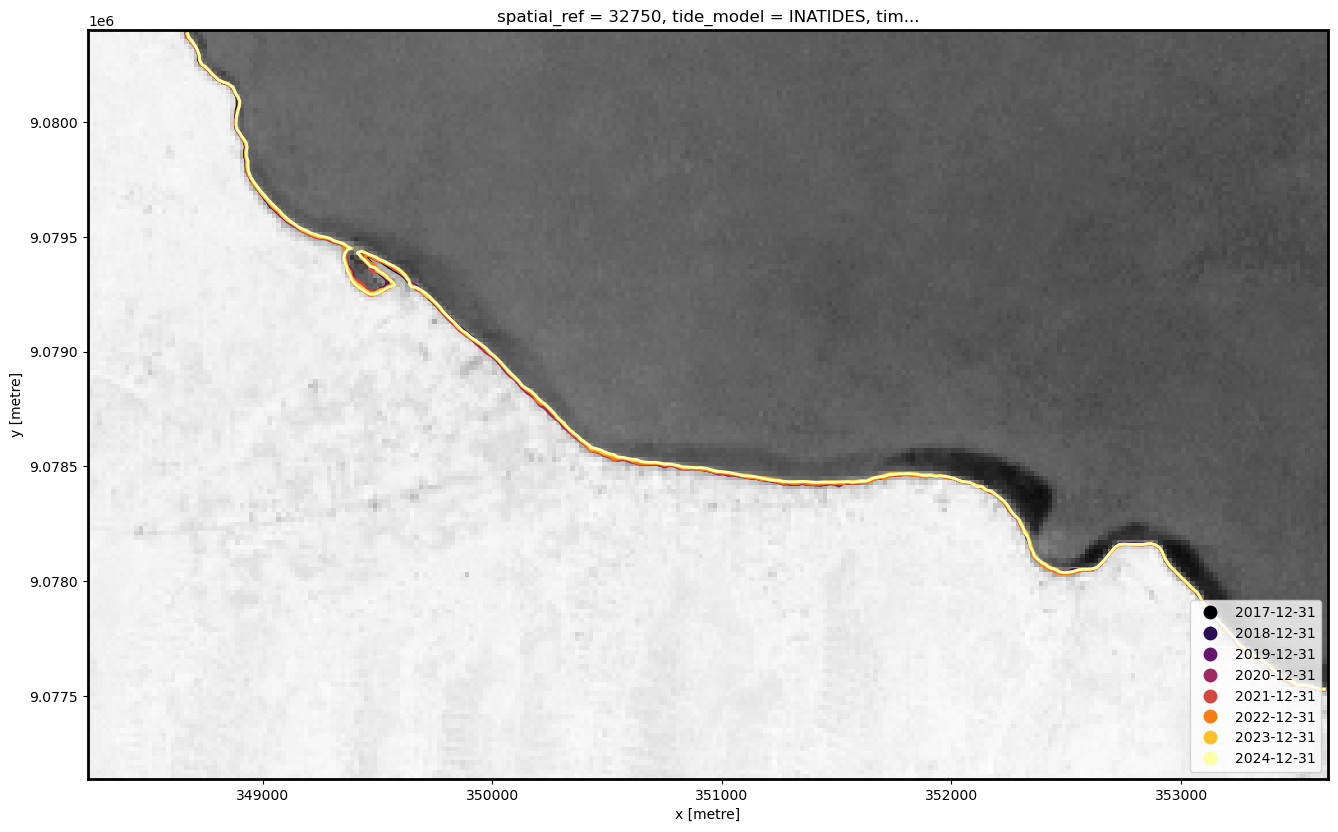

In [128]:
# Extract waterlines
contours_gdf = subpixel_contours(da=sentinel_summaries,
                                 z_values=0,
                                 output_path=f'/home/ubuntu/Scripts/users/teguh/coastline_INATIDES.geojson',
                                 min_vertices=200)

# Plot output shapefile over the first MNDWI layer in the time series
sentinel_summaries.isel(time=0).plot(size=12, 
                                    cmap='Greys', 
                                    add_colorbar=False)
contours_gdf.plot(ax=plt.gca(), 
                  column='time',
                  cmap='inferno',
                  linewidth=2,
                  legend=True,
                  legend_kwds={'loc': 'lower right'})


## Drawing conclusions

Here are some questions to think about:

* What can you conclude about the change in the shoreline? 
* Which sections of the shoreline have seen the most change? 
* Is the change consistent with erosion? 
* What other information might you need to draw additional conclusions about the cause of the change?

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Discord chat](https://discord.com/invite/4hhBQVas5U) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [GitHub](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** December 2023

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
<!-- Browse all available tags on the DEA User Guide's [Tags Index](https://knowledge.dea.ga.gov.au/genindex/) -->